Kerrian LE CAILLEC - Thomas MIGLIASSO

## TP Question IV

1. Tracer le prix EDP du call européen dans le modèle de Black & Scholes en fonction de $S_0$,
puis tracer l’écart entre le prix EDP et le prix exact de la formule de Black & Scholes en
fonction de $S_0$.

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import norm, skew, kurtosis
import scipy.stats.stats as st
import matplotlib.pyplot as plt

In [98]:
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 250
M = 10000
Smax = 150

In [ ]:
def call_price_black_scholes(K, T, S0, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    Parameters:
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        S0 (float): Current price of the underlying asset.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset.
    Returns:
        float: The Black-Scholes price of the European call option.
    
    """
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [ ]:
def compute_tridiagonal_coeffs(sigma, r, T, Smax, N, M):
    """
    Compute the matrix diagonals for the Euler's scheme
    Parameters:
    - sigma(float): volatility
    - r(float): risk-free rate
    - T(float): time to maturity
    - Smax(float): maximum value of the underlying asset
    - N(int): number of space steps
    - M(int): number of time steps
    return:
    - h(float): space step
    - delta_T(float): time step
    - a(float): lower diagonal
    - b(float): main diagonal
    - c(float): upper diagonal
    """
    h = 2 * np.log(Smax) / N
    delta_T = T / M
    b = -(sigma**2 / h**2 + r)
    a = (sigma**2 * (1 / h + 1 / 2) - r) / (2 * h)
    c = (sigma**2 * (1 / h - 1 / 2) + r) / (2 * h)
    return h, delta_T, a, b, c

In [100]:
def thomas_algorithm(N, a, b, c, d):
    """
    Solves a tridiagonal system Ax = d using the Thomas algorithm.

    Parameters:
    - a: Subdiagonal (length n-1)
    - b: Main diagonal (length n)
    - d: Right-hand side vector (length n)

    Returns:
    - x: Solution vector (length n)
    """
    c_prime = np.zeros(N - 1)
    d_prime = np.zeros(N)
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, N):
        denom = b[i] - a[i - 1] * c_prime[i - 1]
        if i < N - 1:
            c_prime[i] = c[i] / denom
        d_prime[i] = (d[i] - a[i - 1] * d_prime[i - 1]) / denom

    x = np.zeros(N)
    x[-1] = d_prime[-1]
    for i in range(N - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]

    return x


def tridiagonal_inverse(N, a, b, c):
    """
    Computes the inverse of a tridiagonal matrix using Thomas' algorithm.

    Parameters:
    - a: Subdiagonal
    - b: Main diagonal

    Returns:
    - A_inv: Inverse of the tridiagonal matrix (n x n)
    """
    A_inv = np.zeros((N, N))
    c_list = c * np.ones(N - 1)
    a_list = a * np.ones(N - 1)
    b_list = b * np.ones(N)

    id_matrix = np.eye(N)
    for i in range(N):
        A_inv[:, i] = thomas_algorithm(N, a_list, b_list, c_list, id_matrix[:, i])

    return A_inv

In [130]:
def euler_implicit_scheme(N, M, Smax, K, r, sigma, full_matrix=False):
    """
    Computes the price of a European call option using the Euler scheme.

    Parameters:
    - N: Number of space steps
    - M: Number of time steps
    - Smax: Maximum value of the underlying asset
    - K: Strike price
    - r: Risk-free rate
    - sigma: Volatility
    - full_matrix: Whether to return the full matrix of option prices for all time steps
    """
    U0 = np.maximum(np.exp(np.linspace(-np.log(Smax), np.log(Smax), N)) - K, 0)
    h, delta_T, a, b, c = compute_tridiagonal_coeffs(sigma, r)
    euler_matrix = tridiagonal_inverse(N + 1, -delta_T * a, 1 - delta_T * b, -delta_T * c)
    U = np.concatenate([[0], U0])
    if full_matrix:
        U_matrix = np.zeros((N + 1, M + 1))
        U_matrix[:, 0] = U
    for j in range(M + 1):
        U[:] = euler_matrix @ U
        U[0] = 0
        U[-1] = Smax - K*np.exp(-r * j*delta_T)
        if full_matrix:
            U_matrix[:, j] = U
    return (U_matrix, delta_T) if full_matrix else U

In [102]:
Uj = euler_implicit_scheme(N, M, Smax, K, r, sigma)

Text(0, 0.5, 'Price')

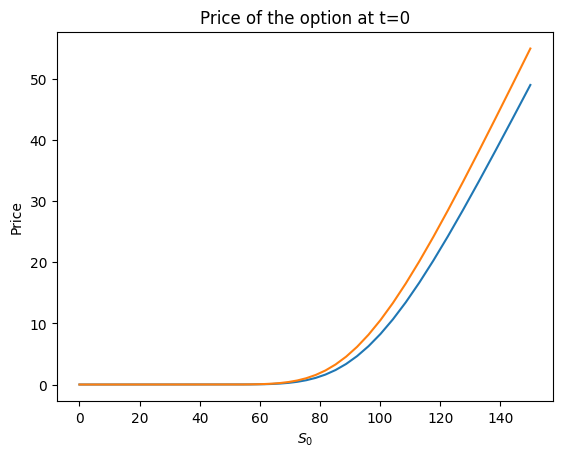

In [108]:
plt.plot(np.exp(np.linspace(-np.log(Smax), np.log(Smax), N - 1)), Uj[1:-1])
plt.plot(
    np.exp(np.linspace(-np.log(Smax), np.log(Smax), N - 1)),
    call_price_black_scholes(
        K, T, np.exp(np.linspace(-np.log(Smax), np.log(Smax), N - 1)), r, sigma
    ),
)
plt.title("Price of the option at t=0")
plt.xlabel("$S_0$")
plt.ylabel("Price")

Text(0, 0.5, 'Error')

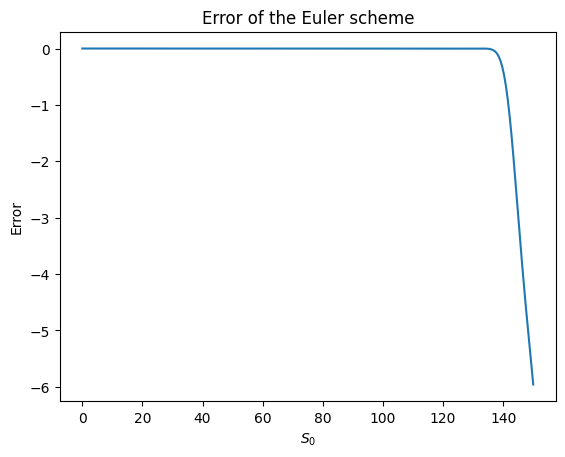

In [ ]:
plt.plot(
    np.linspace(np.exp(-np.log(Smax)), Smax, N - 1),
    Uj[1: -1]
    - call_price_black_scholes(
        K, T, np.exp(np.linspace(-np.log(Smax), np.log(Smax), N - 1)), r, sigma
    ),
)
plt.title("Error of the Euler scheme (PDE price - Black-Scholes price)")
plt.xlabel("$S_0$")
plt.ylabel("Error")


2. Tracer l'erreur en norme $\|\cdot\|_\infty$ du vecteur de prix EDP en fonction de N (à M
suffisamment grand fixé). Retrouve-t-on l’ordre de convergence attendu ? Interpréter la
forme de la courbe.

In [122]:
def absolute_error_N(Smax, K, T, sigma, r, N_range=range(100, 1000, 10)):
    """
    Compute the max absolute error of the Euler scheme for different values of N
    parameters:
    - Smax(float): maximum value of the underlying
    - K(float): strike price
    - T(float): maturity
    - sigma(float): volatility
    - r(float): risk-free rate
    - N_range(range): range of N values
    Returns:
    - results(list): list of the max absolute error for N_range
    """
    results = []
    for N in N_range:
        Uj = euler_implicit_scheme(N, M, Smax, K, r, sigma)
        results.append(
            np.max(
                np.abs(
                    Uj[1:-1]
                    - call_price_black_scholes(
                        K,
                        T,
                        np.exp(np.linspace(-np.log(Smax), np.log(Smax), N - 1)),
                        r,
                        sigma,
                    )
                )
            )
        )
    return results

Text(0, 0.5, 'Max absolute error')

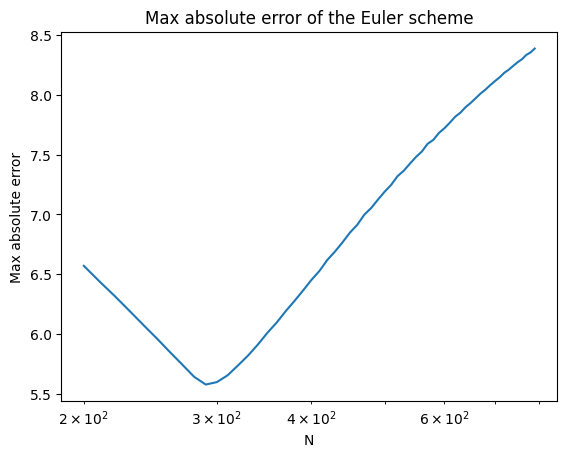

In [123]:
plt.plot(
    range(200, 800, 10),
    absolute_error_N(Smax, K, T, sigma, r, range(200, 800, 10)),
)
plt.title("Max absolute error of the Euler scheme")
plt.xlabel("N")
plt.xscale("log")
plt.ylabel("Max absolute error")

Pour $M=10000$ fixé, on remarque que le minimum de l'erreur absolue maximale est autour de $N=300$. Néanmoins on remarque que plus $N$ est grand plus l'erreur augmente, l'approximation en $M$ n'est alors plus suffisante. 

2. Tracer l'erreur en norme $\|\cdot\|_\infty$ du vecteur de prix EDP en fonction de M (à N suffisamment grand fixé). Retrouve-t-on l’ordre de convergence attendu ? Interpréter la
forme de la courbe.

In [124]:
def absolute_error_M(Smax, K, T, sigma, r, M_range=range(100, 10000, 10)):
    """
    Compute the max absolute error of the Euler scheme for different values of N
    parameters:
    - Smax(float): maximum value of the underlying
    - K(float): strike price
    - T(float): maturity
    - sigma(float): volatility
    - r(float): risk-free rate
    - M_range(range): range of M values
    Returns:
    - results(list): list of the max absolute error for M_range
    """
    results = []
    for m in M_range:
        Uj = euler_implicit_scheme(N, m, Smax, K, r, sigma)
        results.append(
            np.max(
                np.abs(
                    Uj[1:-1]
                    - call_price_black_scholes(
                        K,
                        T,
                        np.exp(np.linspace(-np.log(Smax), np.log(Smax), N - 1)),
                        r,
                        sigma,
                    )
                )
            )
        )
    return results

Text(0, 0.5, 'Max absolute error')

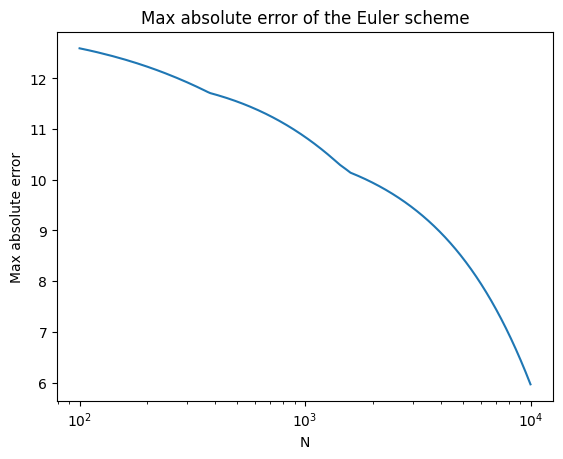

In [ ]:
plt.plot(
    range(100, 10000, 10),
    absolute_error_M(Smax, K, T, sigma, r, range(100, 10000, 10)),
)
plt.title("Max absolute error of the Euler scheme")
plt.xlabel("N")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Max absolute error")

4. Tracer l’erreur ponctuelle $|u^j_i − u(j\Delta T , y_i )|$ en fonction de $t = T − j\Delta T \in [0, T ]$ et $S = e^{y_i} \in [e^{−L}, e^L]$.

In [ ]:
def pointwise_error(Smax, K, T, sigma, r, N, M):
    """
    Compute the pointwise error of the Euler scheme
    parameters:
    - Smax(float): maximum value of the underlying
    - K(float): strike price
    - T(float): maturity
    - sigma(float): volatility
    - r(float): risk-free rate
    - N(int): number of space steps
    - M(int): number of time steps
    Returns:
    - error(float): pointwise error
    """
    Uij, delta_T = euler_implicit_scheme(N, M, Smax, K, r, sigma, full_matrix=True)
    Ubs = np.concatenate(
        [
            call_price_black_scholes(
                K,
                T - j * delta_T,
                np.exp(np.linspace(-np.log(Smax), np.log(Smax), N - 1)),
                r,
                sigma,
            )
            for j in range(M)
        ]
    ).reshape(N - 1, M)
    return np.abs(Uij[1:-1, 1:] - Ubs)

In [ ]:
def plot_heatmap(cmap="viridis"):
    """
    Plots a heatmap for the pointwise error of the Euler scheme

    Parameters:
    - data (numpy.ndarray): The input data array
    - cmap (str): The colormap to use for the heatmap
    """
    errors = pointwise_error(Smax, K, T, sigma, r, N, M)
    plt.figure(figsize=(10, 8))
    x_axis = np.exp(np.linspace(-np.log(Smax), np.log(Smax), N - 1))
    y_axis = np.linspace(0, T, M)

    plt.imshow(errors, cmap=cmap)
    plt.colorbar()
    plt.title("Heatmap of poitwise error for the Euler scheme given $e^Y$ and $t$")	
    plt.xlabel("$e^Y$")
    plt.ylabel("$t$")
    plt.show()


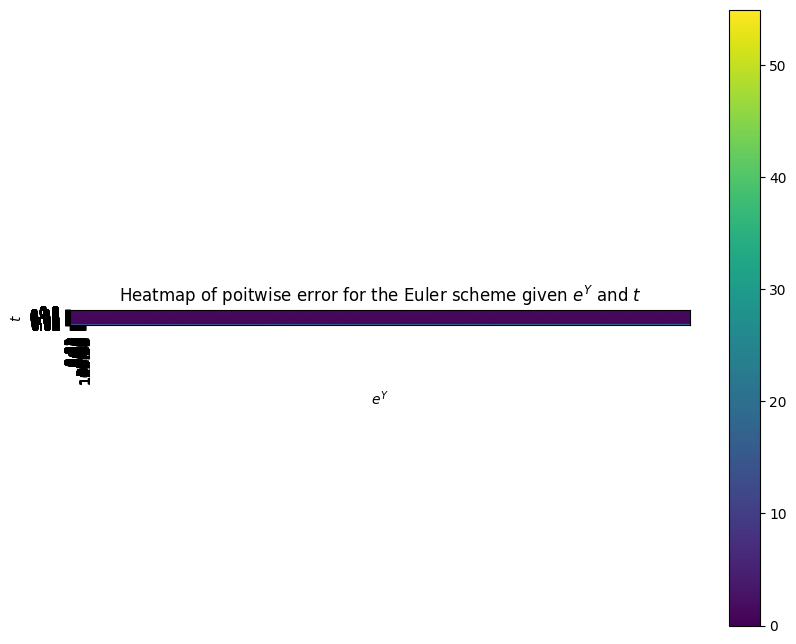

In [143]:
plot_heatmap()